# Computer Vision Coursework Submission (IN3060)

**Student name, ID and cohort:** Mohamad Kanso(200007917) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [82]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Models', 'Personal_Dataset', 'Code', 'CW_Dataset', 'test_functions.ipynb']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import classification_report
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import layers, models

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` to avoid having to reload them each time.

In [84]:
import joblib

svm = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'hog-svm.joblib'))
mlp = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'hog-mlp.joblib'))
knn = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'hog-knn.joblib'))
cnn = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'cnn.joblib'))


# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [85]:
pass

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

In [86]:
from skimage.feature import hog

def extract_hog_features_svm_knn_cnn(image):
    fd, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(3, 3), channel_axis=-1, visualize=True, multichannel=True)
    return fd

def extract_hog_features_mlp(image):
    if image.ndim == 2:
        fd, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    else:
        fd, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True, channel_axis=2)
    return fd   

def MaskDetection(path_to_testset, model_type):
    models = {
        'hog-svm': svm,
        'hog-mlp': mlp,
        'hog-knn': knn,
        'cnn': cnn
    }
    model = models[model_type]
    test_images_path = os.path.join(path_to_testset, "images")
    test_labels_path = os.path.join(path_to_testset, "labels")
    test_files = os.listdir(test_images_path)


    # Load 4 random images from the test set
    random_files = random.sample(test_files, 4)
    images = []
    labels = []
    for filename in random_files:
        img = Image.open(os.path.join(test_images_path, filename)).convert('RGB')
        if model_type == 'cnn':
            img = img.resize((model.input_shape[1], model.input_shape[2]))
        else:
            img = img.resize((224, 224))
        img_arr = np.array(img)
        images.append(img_arr)
        
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_file_path = os.path.join(test_labels_path, label_filename)
        with open(label_file_path, 'r') as f:
            text = f.read().strip()
            label = int(text)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    # Make predictions

    if model_type == "cnn":
        predictions = np.argmax(model.predict(images / 255.0), axis=-1)
    elif model_type == "hog-mlp":
        images_hog = [extract_hog_features_mlp(img) for img in images]
        predictions = model.predict(images_hog)
    else:
        images_hog = [extract_hog_features_svm_knn_cnn(img) for img in images]
        predictions = model.predict(images_hog)

    # Display images with predictions and ground-truth labels
    class_names = {0: "no_mask", 1: "mask", 2: "improper_mask"}
    true_labels = [class_names[label] for label in labels]
    pred_labels = [class_names[pred] for pred in predictions]

    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(4):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {true_labels[i]}\nPredicted: {pred_labels[i]}", fontsize=12)
        axes[i].axis('off')

    plt.show()


The MaskDetection function takes in two arguments: path_to_testset and model_type. It loads the model specified by the model_type argument and the test data located at path_to_testset. 

It then moves on to load 4 random images from the test set, resizes them based on the model type and converts them to arrays. 

It then extracts features from the images and makes predictions using the loaded model. 

After all this is done, it displays the images and their true and predicted labels. If the model type is cnn, the predictions are made using the model's predict method, while for hog-mlp and hog-knn models, the predictions are made by extracting HOG features from the images first.


1/1 [==============================] - 1s 575ms/step


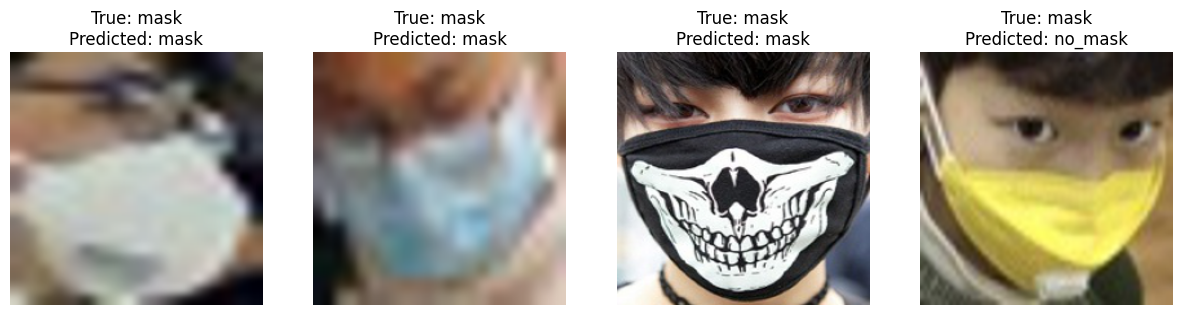

In [89]:
# Syntax for the next function is the following:
# 
# MaskDetection(path_to_testset, model_type)
# 
# where model_type can be one of
#   - hog-svm
#   - hog-mlp
#   - hog-knn
#   - cnn

# Example usage
path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
MaskDetection(path_to_testset, 'cnn')  # Use 'hog-svm' as the model_type


# Test MaskDetection in the wild

This section should allow a quick test of the `MaskDetection` on your `Personal_Dataset`.

1/1 [==============================] - 0s 129ms/step


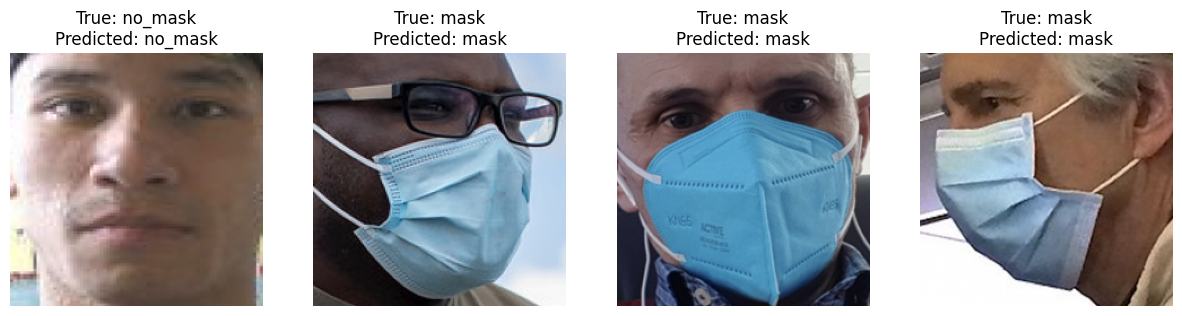

In [91]:
# Syntax for the next function is the following:
# 
# MaskDetection(path_to_testset, model_type)
# 
# where model_type can be one of
#   - hog-svm
#   - hog-knn
#   - hog-mlp
#   - cnn

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
MaskDetection(path_to_testset, 'cnn')